 # Group 97 - Machine Learning 
 Ilaria Crivellari, Kirill -surname-, Moritz -surname-
 
 ## Long Notebook

### Search Domain knowledge

The team made some initial researches to explore the domain model. We found some useful papers on Google Scholar that helped us to understand better the situation.
Examples of the paper we found are the following:
- https://www.researchgate.net/publication/227488895_The_price_of_Moscow_apartments
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3374436

As a result of studying these papers we decided to include the list of metro station in the project.

Morover we found an interesting old competition on kaggle (https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/35585) that included many more data related to the mapping of the buildings in the sub areas and we included also these data in the project.


## Loading data

In [1]:
from math import radians
import numpy as np
import pandas as pd
import geopandas as gp
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.neighbors import BallTree, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics.pairwise import haversine_distances
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


# Reading CSV-files
apartments_train = pd.read_csv("data/apartments_train.csv")
buildings_train = pd.read_csv("data/buildings_train.csv")
apartments_test = pd.read_csv("data/apartments_test.csv")
buildings_test = pd.read_csv("data/buildings_test.csv")
subareas = pd.read_csv("data/sberbank_sub_areas.csv")
sub_areas_df = gp.read_file('./data/mo_kag_SRHM.shp')

# Merge Tables: Apartments and Buildings
train_df = apartments_train.merge(buildings_train, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
test_df = apartments_test.merge(buildings_test, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')

# Splitting data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_df, train_df.price, train_size=0.999, random_state=0)
X_train = X_train.drop(['building_id', 'street', 'price', 'id_r', 'address', 'area_living', 'area_kitchen', 'rooms'], axis=1)
print(train_df["building_id"].shape)
print(train_df["building_id"].unique().shape)
X_val = X_val.drop(['building_id', 'street', 'price', 'id_r', 'address', 'area_living', 'area_kitchen', 'rooms'], axis=1)
X_test = test_df.drop(['building_id', 'id_r', 'street', 'address'], axis=1)

train_df.describe()


(23285,)
(6791,)


,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,center_distance,price_avg,closest_metro
count,14455.000000,2.328500e+04,23285.000000,18564.000000,19403.000000,23285.000000,23285.000000,5643.000000,12192.000000,19413.000000,...,23285.000000,22928.000000,22928.000000,22928.000000,16497.000000,14474.000000,15124.000000,23285.000000,2.315500e+04,23285.000000
mean,1.875683,2.355617e+07,74.450999,12.552279,38.741367,8.969594,2.189349,1.039695,3.268374,0.737547,...,17.608933,0.392620,0.929867,0.743109,0.572589,0.806411,0.176012,0.154858,2.365041e+07,0.020317
std,1.089518,5.264393e+07,58.671373,6.565686,31.398480,8.322039,1.076130,0.351507,10.802728,0.781173,...,11.216638,0.488344,0.255376,0.436928,0.549630,0.395124,0.566275,0.101090,2.237497e+07,0.044926
min,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001904,5.706130e+06,0.000116
25%,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,...,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.089378,1.057349e+07,0.006994
50%,2.000000,1.064500e+07,59.800000,10.700000,30.900000,7.000000,2.000000,1.000000,2.800000,1.000000,...,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.136458,1.658807e+07,0.010860
75%,3.000000,2.050000e+07,84.800000,15.300000,45.300000,12.000000,3.000000,1.000000,3.000000,1.000000,...,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.202623,1.974773e+07,0.017198
max,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,340.000000,4.000000,...,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,0.806078,8.392784e+07,0.512452


## EDA
We extensively explorated the data, both single features and relation between them.



### Analyze Target Distribution

Log-transform target variable:

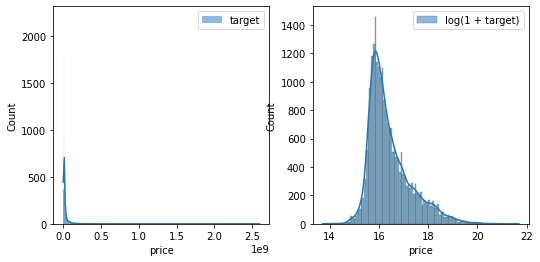

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(left=-0.2)

trans_data = pd.DataFrame(np.log1p(train_df["price"]), columns=["price"])

sns.histplot(train_df, x="price", label="target", kde=True, ax=ax1)
sns.histplot(trans_data, x="price", label="log(1 + target)", kde=True, ax=ax2)

ax1.legend()
ax2.legend();

## Plot Covariance

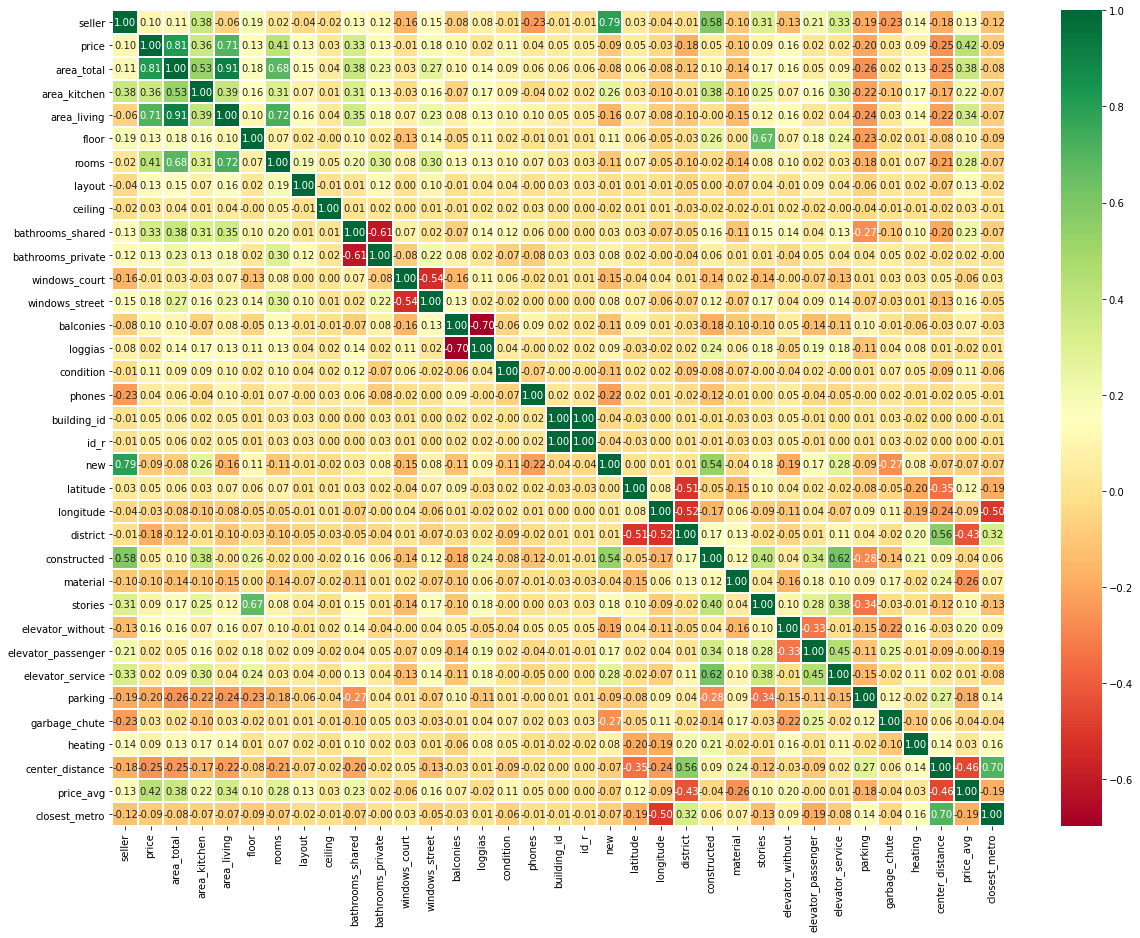

In [3]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), xticklabels=True, yticklabels=True, cmap='RdYlGn', linewidths=.2, annot=True, fmt=".2f");

## Data cleaning

We found out that there were some ouliers in th data and we tried to clean them.

In [ ]:
#CEILING
all_data = pd.concat([train_df, test_df])

plt.plot(all_data.ceiling)
print("Amount of ceilings higher than 200m: ", len(all_data.ceiling[all_data.ceiling >200]))
print("Amount of ceilings between 25m and 200m: ", len(all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)]))
# Rescaling out of scale ceilings
all_data.ceiling[all_data.ceiling > 200] = all_data.ceiling/100
all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)] = all_data.ceiling/10

In [ ]:
#AREA
fig1, pl1 = plt.subplots(figsize=(20,10))
fig2, pl2 = plt.subplots(figsize=(20,10))
fig3, pl3 = plt.subplots(figsize=(20,10))
pl1.plot(all_data.area_total)
pl1.set_title("total area")
pl2.plot(all_data.area_kitchen/all_data.area_total)
pl2.set_title("kitchen")
pl3.plot(all_data.area_living/all_data.area_total)
pl3.set_title("living")

print("TEST Amount of flat with area > 1000 : ", len(test_df.area_total[test_df.area_total >1000]))
print("TEST Amount of flat with area < 10 : ", len(test_df.area_total[test_df.area_total <10]))

print("TRAIN Amount of flat with area > 1000 : ", len(train_df.area_total[train_df.area_total >1000]))
print("TRAIN Amount of flat with area < 10 : ", len(train_df.area_total[train_df.area_total <10]))


print("TRAIN Amount of flat with living > total : ", len(train_df.area_living[train_df.area_living > train_df.area_total]))
print("TEST Amount of flat with living > total : ", len(test_df.area_living[test_df.area_living > test_df.area_total]))

print("TRAIN Amount of flat with living > total : ", len(train_df.area_living[train_df.area_living + train_df.area_kitchen > train_df.area_total]))
print("TEST Amount of flat with living > total : ", len(test_df.area_living[test_df.area_living + test_df.area_kitchen> test_df.area_total]))


fig4, pl4 = plt.subplots(figsize=(20,10))
pl4.bar(all_data.index[all_data.area_living>all_data.area_total], all_data.area_living[all_data.area_living>all_data.area_total]/all_data.area_total[all_data.area_living>all_data.area_total])

#cleaning area data
wrong_kitch_sq_index = all_data['area_kitchen'] > all_data['area_total']
all_data.loc[wrong_kitch_sq_index, 'area_kitchen'] = all_data.loc[wrong_kitch_sq_index, 'area_total'] * 1 / 3

wrong_life_sq_index = all_data['area_living'] > all_data['area_total']
all_data.loc[wrong_life_sq_index, 'area_living'] = all_data.loc[wrong_life_sq_index, 'area_total'] * 3 / 5

In [ ]:
#ROOMS
fig1, pl1 = plt.subplots(figsize=(20,10))
fig2, pl2 = plt.subplots(figsize=(20,10))
pl1.plot(all_data.rooms)
pl1.set_title("rooms")
pl2.plot(all_data.bathrooms_private + all_data.bathrooms_shared)
pl2.set_title("bathrooms")

print("Amount of apartment with 0 rooms: ", len(all_data.rooms[all_data.rooms==0]))
print("Amount of apartment with 0 bathrooms: ", len(all_data[all_data.bathrooms_shared+all_data.bathrooms_private==0]))


In [ ]:
#CONSTRUCTED
print("min construction year: ", min(all_data.constructed))
print("max construction year: ", max(all_data.constructed)) 

#FLOOR
print("Amount of apartment with 0 floors: ", len(all_data[all_data.stories==0]))
print("Amount of apartment with floor bigger than stories: ", len(all_data[all_data.floor>all_data.stories]))

#cleaning floor MAKE IT WORSE (boh substituing floor and stories)
wrong_floor = all_data['floor'] > all_data['stories']
all_data.loc[wrong_floor, 'stories'] = all_data.loc[wrong_floor, 'floor']

## Create new features


In [ ]:
def haversine_array(lat1, lng1, lat2 = 55.75, lng2 = 37.6):
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        AVG_EARTH_RADIUS = 6371  # in km
        lat = lat2 - lat1
        lng = lng2 - lng1
        d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
        h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
        return h

In [ ]:
# Merge features
all_data["street_and_address"] = all_data.street + " " + all_data.address

# Imputing coordinates outside of moscow and NaNs
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 37.4821752
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица 1-я Линия 57"] = 55.6324711
all_data.longitude[all_data.street_and_address == "улица 1-я Линия 57"] = 37.4536057
all_data.latitude[all_data.street_and_address == "улица Центральная 75"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 75"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица Центральная 48"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 48"] = 37.4821752

# NaNs
all_data.latitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 55.5676692
all_data.longitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 37.4816608

# Encode strings to integers
all_data["street_and_address"] = LabelEncoder().fit_transform(all_data.street_and_address)

# Average price per district
mean_price = train_df.groupby('district').mean().reset_index()[['district', 'price']]
train_df = train_df.merge(mean_price, how='left', on='district', suffixes=('', '_avg'))
test_df = test_df.merge(mean_price, how='left', on='district').rename(columns={'price' : 'price_avg'}).set_index(test_df.index)

# Distance to nearest metro station
metro_locs = pd.read_csv("data/metro_stations.csv")[['longitude','latitude']].to_numpy()
house_locs_train = train_df[['longitude','latitude']].to_numpy()
house_locs_test = test_df[['longitude','latitude']].to_numpy()
dists_train = np.min(np.linalg.norm(house_locs_train[:, np.newaxis, :] - metro_locs, axis=2), axis=1)
dists_test = np.min(np.linalg.norm(house_locs_test[:, np.newaxis, :] - metro_locs, axis=2), axis=1)
train_df['closest_metro'] = dists_train
test_df['closest_metro'] = dists_test

# Add nearest sub_area to each building
bulding_locs = np.asarray(list(zip(all_data['latitude'], all_data['longitude'])))
sub_area_locs = np.asarray(list(zip(subareas['longitude'], subareas['latitude'])))
closest_sub_idx = np.argmin(haversine_distances(bulding_locs, sub_area_locs), axis=1)
all_data["sub_area_"] = subareas['sub_area'].iloc[closest_sub_idx].values
all_data["sub_area_"] = LabelEncoder().fit_transform(all_data['sub_area_'])

# Mapping each building to its sub_area
geo_df = gp.GeoDataFrame(all_data, geometry=gp.points_from_xy(all_data.longitude, all_data.latitude))
geo_df.crs = "EPSG:4326"
all_data = gp.sjoin(sub_areas_df, geo_df, how='right', predicate='contains')
all_data = all_data.drop(["DISTRICT", "geometry", "OKATO", "OKTMO", "OKATO_AO", "index_left"], axis=1)
all_data["sub_area"] = LabelEncoder().fit_transform(all_data['sub_area'])

pca = PCA(n_components=1)
all_data["sub_area_pca"] = pca.fit_transform(all_data[["sub_area", "sub_area_"]]).squeeze()
all_data = all_data.drop(["sub_area", "sub_area_"], axis=1)


# Add distance from city center
all_data['center_distance'] = haversine_array(all_data['latitude'], all_data['longitude'])

# Add closest metro_station
metro_locs = np.asarray(list(zip(metro_locs['latitude'], metro_locs['longitude'])))
closest_metro_dist = np.min(haversine_distances(bulding_locs, metro_locs), axis=1)
all_data['closest_metro'] = closest_metro_dist

# Add average price in the neighborhood
tree = BallTree(all_data[["latitude", "longitude"]])
dist, ind = tree.query(all_data[["latitude", "longitude"]], k=300)

# Take log of area
all_data['area_total'] = np.log(all_data['area_total'])
mean_sqm_price = []
mean_subarea_price = []

for rows in ind:
    mean_sqm_price.append(np.nanmean(all_data['price'].iloc[rows] / all_data['area_total'].iloc[rows]))
    mean_subarea_price.append(np.nanmean(all_data['price'].iloc[rows]))


all_data["mean_sqm_price"] = mean_sqm_price
# all_data["mean_subarea_price"] = mean_subarea_price

#Add floor distance from the top of the building and the percentage of the floor
all_data['floor_from_top'] = all_data['stories'] - all_data['floor']
all_data['floor_over_stories'] = all_data['floor'] / all_data['stories']

#examining year 
all_data['age_of_house_before_sale'] = np.where((2018 - all_data['constructed']>0), 2018 - all_data['constructed'], 0)
all_data['sale_before_build'] = ((2018 - all_data['constructed']) < 0).astype(int)

#Add area percentage
all_data['area_kitchen_percentage']= all_data['area_kitchen'] / all_data['area_total']
all_data['area_living_percentage']= all_data['area_living'] / all_data['area_total']